---
title: "Automatic differentiation"
author: "Marcin Płodzień"
toc: true
number-sections: true
highlight-style: pygments
jupyter: python3
skip_showdoc: true
skip_exec: true
---

# Automatic differentiation

Automatic differentiation (also known as "autodiff") is a method for efficiently calculating the derivatives of a function represented as a computer program. It allows developers to accurately and efficiently compute gradients of a function with respect to its input variables.

The basic idea behind autodiff is to use the chain rule of calculus to decompose the derivative of a complex function into the derivative of a sequence of simpler functions. This process is typically done by traversing a computational graph that represents the function and applying the chain rule at each step.

In machine learning, for example, autodiff is used to compute gradients of a loss function with respect to the model's parameters, which are then used to update the model via gradient descent or some other optimization algorithm.

One of the key advantages of autodiff is that it allows developers to compute gradients of a function without having to manually derive the gradient expressions themselves. 

There are two main approaches to automatic differentiation: forward mode and reverse mode (backpropagation).

Forward mode autodiff works by evaluating the function and its derivative at the same time, using the chain rule to propagate derivatives through the computation. This is efficient when the number of input variables is small, but can be inefficient when the number of input variables is large because it requires storing the intermediate derivative values.

Reverse mode autodiff, also known as backpropagation, works by first evaluating the function, then going backwards and using the chain rule to compute the derivatives of the input variables with respect to the output. This is efficient when the number of input variables is large, but can be inefficient when the number of input variables is small.

## Computational graph

A computational graph is a graph-based representation of a mathematical computation. It is a way of visually representing the operations performed in a computation, and the dependencies between these operations.

In a computational graph, nodes represent operations, and edges represent the data that flows between these operations.

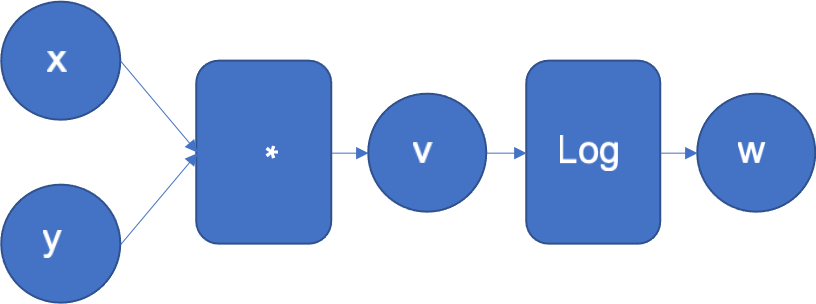


By combining the derivatives of the simpler functions that compose a larger one, such as a neural network, it is possible to compute the exact value of the gradient at a given point rather than relying on the numerical approximation, which would require multiple perturbations in the input to obtain a value.



## torch.autograd

torch.autograd is PyTorch’s automatic differentiation engine that helps in neural network training.


### Example 1

To compute the gradient of a scalar function $f$ with respect to a single variable $x$, we can use PyTorch's autograd module. For example:

In [ ]:
import torch

# Create a tensor with requires_grad set to True
x = torch.tensor([4.0], requires_grad=True)

# Define a scalar function f
def f(x):
    return x ** 2

# Compute the gradient of f with respect to x
y = f(x)
y.backward()

# The gradient of f with respect to x is stored in x.grad
print(x.grad)  # Output: 2.0

### Example 2

To compute the gradient of a function with respect to multiple variables, we can pass a tensor with requires_grad set to True to the function and then use the backward method on the resulting tensor.  

In [ ]:
import torch

# Create tensors with requires_grad set to True
x = torch.tensor([1.0], requires_grad=True)
y = torch.tensor([1.0], requires_grad=True)
z = torch.tensor([1.0], requires_grad=True)
# Define a function that takes two variables as input and returns their sum
def f(x, y, z):
    return torch.log(torch.sin(x) + torch.tanh(y**2))/z

# Compute the gradient of f with respect to x and y
g = f(x, y, z)
g.backward()

# The gradients of f with respect to x and y are stored in x.grad and y.grad
print(x.grad)  # Output: 1.0
print(y.grad)  # Output: 1.0
print(z.grad)  # Output: 1.0

### Example 3

Let us consider eigenproblem for quantum harmonic oscillator

\begin{equation}
\begin{split}
\hat{H}\psi_n(x) & = E_n(x)\psi_n(x) \\
\hat{H} & = -\frac{1}{2}\frac{\partial^2}{\partial x^2} + \frac{1}{2}x^2 + \kappa x^4
\end{split}
\end{equation}

We are interested in change of the energy gap $\text{gap} = E_{1} - E_{n}$ as a function of $\kappa$ parameter.

Let's start with defining Hamiltonian and solving eigenproblem:

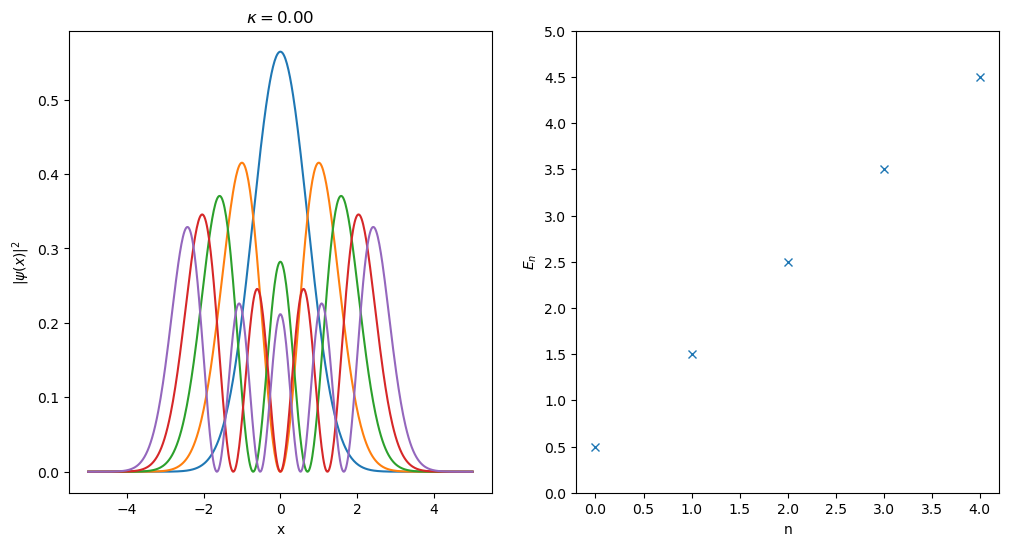

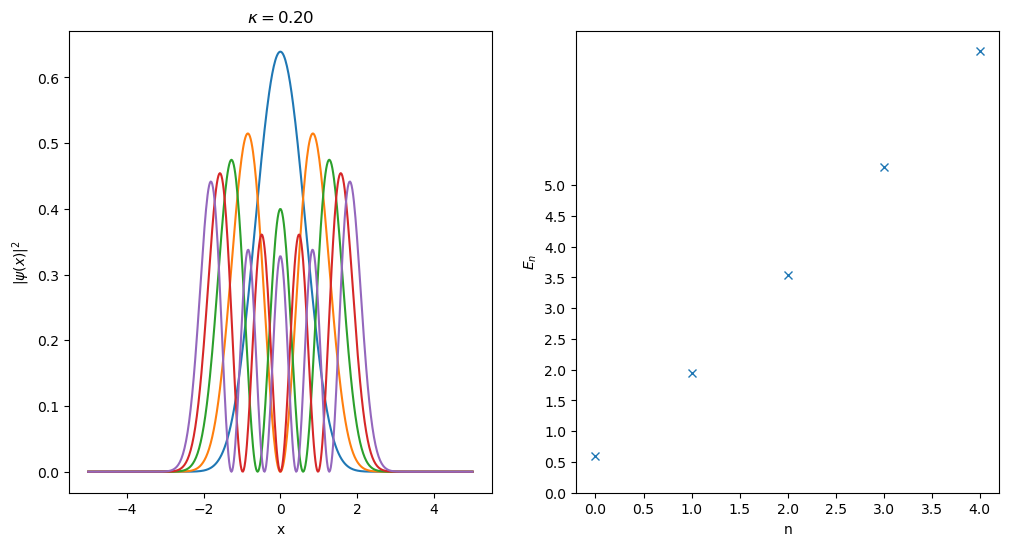

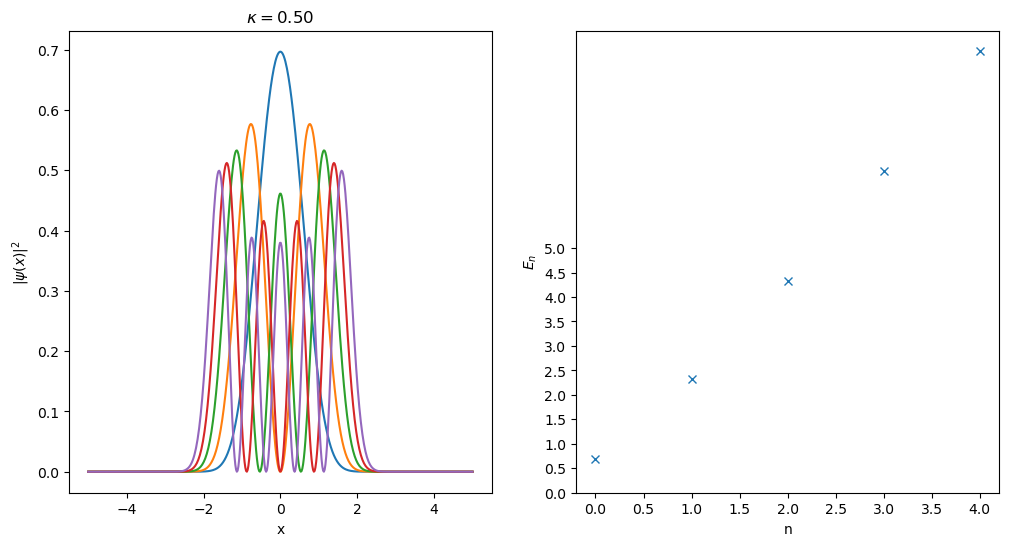

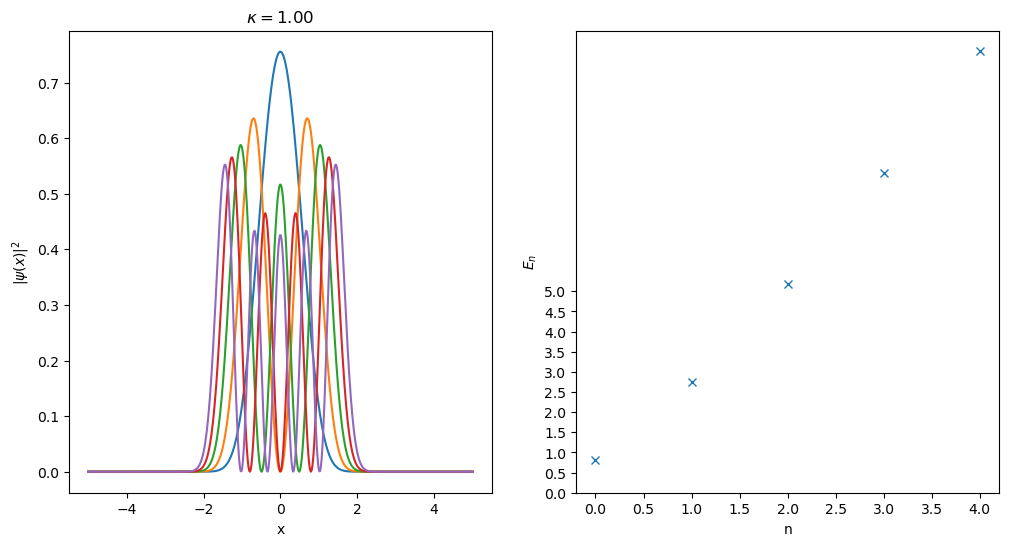

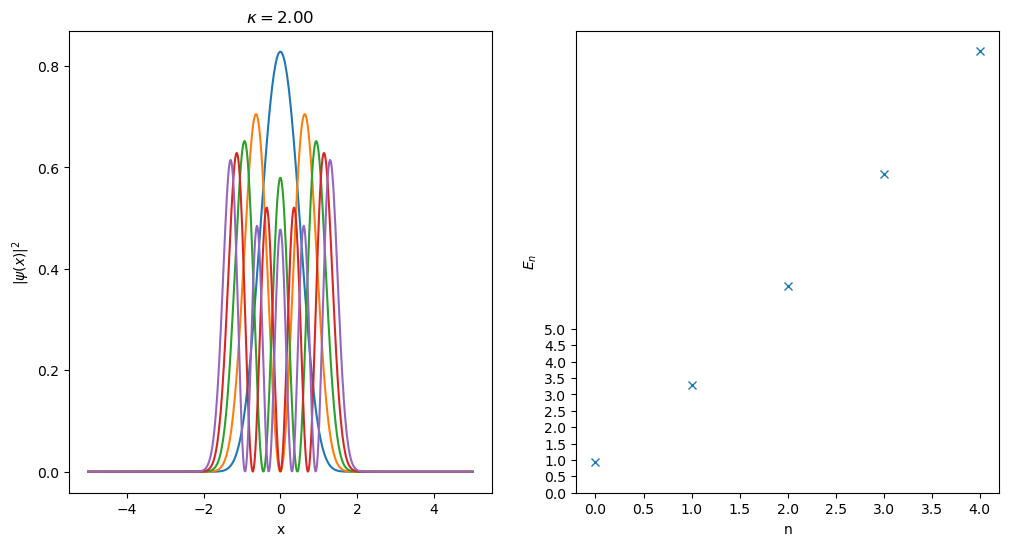

Text(0, 0.5, 'energy gap')

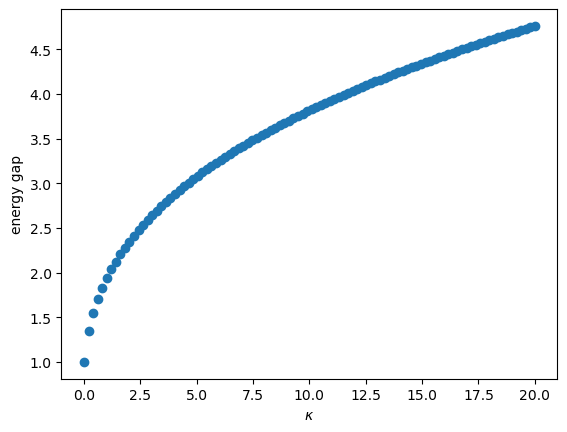

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.linalg import eigh



def get_H(kappa):

    H_T = torch.zeros((Nx,Nx))
    ones = torch.ones(Nx)
    H_T = -0.5/dx**2*( torch.diag_embed(ones[:-1], offset = 1) - 2*torch.diag_embed(ones, offset = 0) + torch.diag_embed(ones[:-1], offset = -1))  

    H_V = torch.diag(0.5*x**2.0 + kappa*x**4.0)
    H = H_T + H_V
    return H


def get_energy_gap(kappa):

    H = get_H(kappa)
    Energies, Vectors = eigh(H)
    energy_gap = Energies[1] - Energies[0]
    
    return energy_gap


L = 10
Nx = 500
x = torch.linspace(-L/2,L/2,Nx)
dx = x[1]-x[0]

kappa_vec = torch.tensor([0, 0.2, 0.5, 1, 2])

for kappa in kappa_vec:
    H = get_H(kappa)
    Energies, Vectors = eigh(H)
    rho = torch.abs(Vectors)**2/dx

    n_max = 5             # maximal number of eigenstates
    E_max = (n_max + 0.5) #
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    ax[0].set_title(r"$\kappa = $" + "{:2.2f}".format(kappa.item()))
    for i in range(0,n_max):
        ax[0].plot(x,rho[:,i].detach().numpy())
    ax[1].plot(Energies[0:n_max].detach().numpy(),'x')
    ax[0].set_ylabel(r"$|\psi(x)|^2$")
    ax[0].set_xlabel("x")
    ax[1].set_ylabel(r"$E_n$")
    ax[1].set_xlabel(r"n")
    ax[1].set_yticks(np.arange(0,E_max,0.5))
    plt.show()


fig = plt.figure()

## How gap = E_{1} - E_{0} depends on kappa?
gap_vs_kappa = []
kappa_vec = np.linspace(0,20,100)
for kappa in kappa_vec:
    gap_vs_kappa.append([get_energy_gap(kappa)])

plt.plot(kappa_vec, gap_vs_kappa, 'o')
plt.xlabel(r"$\kappa$")
plt.ylabel(r"energy gap")


Let's calculate $\frac{d \text{f}(\kappa)}{d \kappa}$ at given $\kappa$:

In [ ]:
kappa_fixed = torch.tensor(0., requires_grad = True)
gap = get_energy_gap(kappa_fixed)
gap.backward()
print(kappa_fixed.grad)

tensor(3.0000)


# Autodiff for custom loss function

A machine learning model $M$ is a function, with inputs $\vec{x}$ and outputs. We can then express the model $M$ as a vector-valued function of the input: $\vec{y} = M(\vec{x})$

Since we’ll mostly be discussing autograd in the context of training, our output of interest will be the model’s loss function $L = L(M(\vec{x}))$, which is a single-valued scalar function of the model’s output. This function expresses how far off our model’s prediction was from a particular input’s ideal output.  

During training the model we aim to minimize the loss function $L$. In the idealized case of a perfect model, that means adjusting its learning weights - that is, the adjustable parameters of the function - such that loss is zero for all inputs. We try to obtain that by an iterative process of passing the training data, and updating the weights according to gradient of the loss function with respect to the training parameters.

Autograd lies at the heart of building machine learning projects. It allows automatic calculation of gradient of the custom loss function for the Neural Network with respect to it's parameters.

Let's consider concrete simple example:

## MNIST dataset

### One-hot encoding of MNIST labels

In the context of the MNIST dataset, one-hot encoding is a way of representing the labels (which are digits between 0 and 9) as 10-dimensional vectors, with all elements set to zero except for the index corresponding to the label value. 
For example, the label 3 would be represented as [0, 0, 0, 1, 0, 0, 0, 0, 0, 0].

One-hot encoding is often used as a way to represent categorical variables in machine learning models. It has the advantage of being able to represent any number of categories, and the labels are mutually exclusive, which can be useful for certain types of models.

### Categorical cross-entropy loss function
One-hot encoding can be understood in terms of discrete probability distribution with $1$ at entry $i$-th enumerating given class $i$. As such, each training sample $\vec{x}$ is accompanied by known, discrete probability distribution $p$ in the form of one-hot encoded label.

The output of the Neural Network $q$ will have also $10$ nodes and we will interpret it as a discrete probability distribution, as well as $p$. Model prediction is a index of $j$ for which $q_j$ is maximal (after softmax activation function).

During training process we will consider loss function as a Kullback-Leibler divergence providing measure of how to probability distributions $p$ and $q$ differs.

\begin{equation}
K_{LB}(p || q) = \sum_{i} p_i\log\frac{p_i}{q_i}.
\end{equation}

We can see that

\begin{equation}
K_{LB}(p || q) = \sum_{i}p_i\log{p_i} -\sum_i p_i\log{q_i} \equiv {\cal H} - \text{CE}(p,q),
\end{equation}
where ${\cal H}$ is Shannon entropy for discrete probability distribution $p$, and
\begin{equation}
\text{CE}(p,q) = -\sum_i p_i\log{q_i}
\end{equation}
is categorical-cross entropy.

Because shannon entropy is constant for given each training sample $\vec{x}$ we take categorical cross-entropy as a loss function.

The class prediction is taken as index $j$ corresponding to the maximum value of the
\begin{equation}
softmax(p) = \frac{e^{-p_j}}{\sum_j e^{-q_j}}
\end{equation}

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)


In [ ]:
# Define the model
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10)
                     )
# Define the loss
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(1, 11):
    running_loss = 0.0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784-dimensional vector
        images = images.view(images.shape[0], -1)
    
        # Clear the gradients
        optimizer.zero_grad()
        
        
        # One-hot encode the labels
        one_hot_labels = torch.zeros(labels.size(0), 10)
        one_hot_labels[torch.arange(labels.size(0)), labels] = 1
                
        # Forward pass
        output = model(images)
        
        # Calculate the loss
        loss = criterion(output, one_hot_labels)        

        # Backward pass
        loss.backward()  # automatic calculating the loss with respects to trainable parameters
        
        # Update the weights according to chosem optimization function. Here: Adam
        optimizer.step()
        
        # Print statistics
        running_loss += loss.item()
    print(f"Epoch {epoch} - Training loss: {running_loss/len(trainloader)}")

Now, evaluate model

In [ ]:
import numpy as np
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
# Set the model to evaluation mode
model.eval()

# Make predictions on the test set
correct = 0
total = 0
confusion_matrix = np.zeros((10,10))
with torch.no_grad():
    for images, labels in testloader:
        # Flatten MNIST images into a 784-dimensional vector
        images = images.view(images.shape[0], -1)
        
        # Forward pass
        output = model(images)
        
        # Apply the softmax function to the output
        probs = torch.softmax(output, dim=1)
        
        # Get the class with the highest probability
        _, predicted = torch.max(probs, 1)
        
        # Update the correct and total counters
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        for i in range(0, predicted.shape[0]):           
            confusion_matrix[predicted[i].item(),labels[i].item()] += 1

# Calculate the accuracy
accuracy = correct / total

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(confusion_matrix)
plt.xlabel("true")
plt.ylabel("predicted")
plt.title("Accuracy = " + "{:2.2f}".format(accuracy*100) + "%")